<a href="https://colab.research.google.com/github/AshrithSagar/CP260-RP-2025/blob/main/1_Lab_CP260_2025_Q.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CP260-2025: Lab 1**

*IMU data processing*

References:

1. An introduction to Inertial Navigation, Woodman et. al., Technical Report 696, University of Cambridge, 2007.

https://www.cl.cam.ac.uk/techreports/UCAM-CL-TR-696.pdf

2. VQF: Highly Accurate IMU Orientation Estimation with Bias Estimation and Magnetic Disturbance Rejection, Laidig & Seel,

Paper: https://arxiv.org/abs/2203.17024
Code: https://github.com/dlaidig/vqf


3. Micro-Lie Theory for State Estimation in Robotics, Sola et. al, https://arxiv.org/abs/1812.01537, 2018


Please write your answers in the cells below For help with Latex notation, see this sites:

1. https://colab.research.google.com/github/bebi103a/bebi103a.github.io/blob/master/lessons/00/intro_to_latex.ipynb

2. https://oeis.org/wiki/List_of_LaTeX_mathematical_symbols

In [ ]:
import numpy as np
import scipy.io as spio
import matplotlib.pyplot as plt

In [ ]:
def QuatFromAngleAxis(w):
  ''' w: ndarray N x 3 shape containing axis-angle in each row
      returns: ndarray N x 4 shape containing corresponding quaternions in each row
  '''
  if (w.ndim == 1):
    ang = np.linalg.norm(w)
    return np.hstack((np.cos(ang/2), np.where(np.isclose(ang,0),np.array([0,0,0.]),np.sin(ang/2)*w/ang)))
  else:
    ang = np.linalg.norm(w,axis=1).reshape(-1,1)
    return np.hstack((np.cos(ang/2), np.where(np.isclose(ang,0),np.array([0,0,0.]),np.sin(ang/2)*w/ang)))

def AngleAxisFromQuat(q):
  ''' q: ndarray N x 4 shape containing quaternions in each row
      returns: ndarray N x 3 shape containing corresponding axis-angles in each row
  '''
  if (q.ndim == 1):
    qn = np.linalg.norm(q[1:])
    return 2*np.arccos(q[0])*(np.where(np.isclose(qn,0),np.array([1.,0,0]),q[1:]/qn))
  else:
    qn = np.linalg.norm(q[:,1:],axis=1).reshape(-1,1)
    return 2*np.arccos(q[:,0]).reshape(-1,1)*(np.where(np.isclose(qn,0),np.array([1.,0,0]),q[:,1:]/qn))

In [ ]:
w = np.array([0,0,np.pi/4])
print(QuatFromAngleAxis(w))
print(AngleAxisFromQuat(QuatFromAngleAxis(w)))

[0.92387953 0.         0.         0.38268343]
[0.         0.         0.78539816]


In [ ]:
aa = np.array([[0,0,np.pi/4],
               [np.pi/2,0,0],
               [0,0,0]
               ])
q=QuatFromAngleAxis(aa)
print(AngleAxisFromQuat(q))
print(np.isclose(np.linalg.norm(AngleAxisFromQuat(q)-aa,axis=1),0))

[[0.         0.         0.78539816]
 [1.57079633 0.         0.        ]
 [0.         0.         0.        ]]
[ True  True  True]


<ipython-input-140-dacbc6d323ef>:10: RuntimeWarning: invalid value encountered in divide
  return np.hstack((np.cos(ang/2), np.where(np.isclose(ang,0),np.array([0,0,0.]),np.sin(ang/2)*w/ang)))
<ipython-input-140-dacbc6d323ef>:21: RuntimeWarning: invalid value encountered in divide
  return 2*np.arccos(q[:,0]).reshape(-1,1)*(np.where(np.isclose(qn,0),np.array([1.,0,0]),q[:,1:]/qn))


In [ ]:
def QuatMultiply(q1, q2):
  ''' q1: ndarray of (4,) or N x 4 shape containing quaternions in each row
      q2: ndarray of (4,) or N x 4 shape containing quaternions in each row
      returns: ndarray (4,) or N x 4 shape containing corresponding product quaternions in each row
  '''
  if (q1.ndim == 1):
    if (q2.ndim == 1):
      return np.hstack((q1[0]*q2[0]-(q1[1:]*q2[1:]).sum(),q1[0]*q2[1:]+q2[0]*q1[1:]+np.cross(q1[1:],q2[1:])))
    else:
      return np.hstack(((q1[0]*q2[:,0]-(q1[1:]*q2[:,1:]).sum(1)).reshape(-1,1),q1[0]*q2[:,1:]+q2[:,0].reshape(-1,1)*q1[1:].reshape(1,-1)+np.cross(q1[1:],q2[:,1:])))
  elif (q2.ndim ==1):
    return np.hstack(((q1[:,0]*q2[0]-(q1[:,1:]*q2[1:]).sum(1)).reshape(-1,1),q1[:,0].reshape(-1,1)*q2[1:].reshape(1,-1)+q2[0]*q1[:,1:]+np.cross(q1[:,1:],q2[1:])))
  else:
    assert q1.shape == q2.shape
    return np.hstack(((q1[:,0]*q2[:,0]-(q1[:,1:]*q2[:,1:]).sum(1)).reshape(-1,1),
                    q1[:,0].reshape(-1,1)*q2[:,1:]+q2[:,0].reshape(-1,1)*q1[:,1:]+np.cross(q1[:,1:],q2[:,1:],axis=1)))

In [ ]:
q1=np.array([[np.cos(np.pi/4),np.sin(np.pi/4),0,0],
             [np.cos(np.pi/4),0,0,np.sin(np.pi/4)]
             ])
q2=np.array([[np.cos(np.pi/4),np.sin(np.pi/4),0,0],
             [np.cos(np.pi/4),0,0,np.sin(np.pi/4)]
             ])
u1=np.array([np.cos(np.pi/4),np.sin(np.pi/4),0,0])
print(QuatMultiply(q1,q2))
print(QuatMultiply(u1,u1))
print(QuatMultiply(q1[0],q1))
print(QuatMultiply(u1,q2[1]))
print(QuatMultiply(q1,q2[0]))

[[2.22044605e-16 1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.22044605e-16 0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[2.22044605e-16 1.00000000e+00 0.00000000e+00 0.00000000e+00]
[[ 2.22044605e-16  1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 5.00000000e-01  5.00000000e-01 -5.00000000e-01  5.00000000e-01]]
[ 0.5  0.5 -0.5  0.5]
[[2.22044605e-16 1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [5.00000000e-01 5.00000000e-01 5.00000000e-01 5.00000000e-01]]


In [ ]:
def QuatInverse(q):
  ''' q: ndarray of (4,) or N x 4 shape containing quaternions in each row
      returns: ndarray (4,) or N x 4 shape containing corresponding inverse quaternions in each row
  '''
  if (q.ndim==1):
    return np.hstack((q[0],-q[1:]))
  else:
    return np.hstack((q[:,0].reshape(-1,1),-q[:,1:]))

def QuatRot(q,v):
  ''' q: ndarray of (4,) or N x 4 shape containing quaternions in each row
      v: ndarray (3,) or N x 3 shape containing vectors in each row
      returns: ndarray (3,) or N x 3 shape containing corresponding vectors in each row
  '''
  #convert vector into a quaternion
  if (v.ndim==1):
    qv = np.hstack((0,v))
  else:
    qv = np.hstack((np.zeros((v.shape[0],1)),v))

  vr = QuatMultiply(QuatMultiply(q,qv),QuatInverse(q))

  if vr.ndim == 1:
    return  vr[1:]
  else:
    return vr[:,1:]

def QuatNormalize(q):
  ''' q: ndarray N x 4 shape containing quaternions in each row
      returns: ndarray N x 4 shape containing corresponding unit quaternions in each row
  '''
  if (q.ndim==1):
    return q/np.linalg.norm(q)
  else:
    return q/np.linalg.norm(q,axis=1).reshape(-1,1)

In [ ]:
q1=np.array([[np.cos(np.pi/4),np.sin(np.pi/4),0,0],
             [np.cos(np.pi/4),0,0,np.sin(np.pi/4)]
             ])
q2=np.array([[np.cos(np.pi/4),np.sin(np.pi/4),0,0],
             [np.cos(np.pi/4),0,0,np.sin(np.pi/4)]
             ])
v1 = np.array([[1,0,0],[0,1,0]])

print(QuatRot(q1,v1))
print(QuatRot(q1,v1[0]))
print(QuatRot(q1[0],v1))
print(QuatRot(q1[1],v1[0]))


[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.00000000e+00  2.22044605e-16  0.00000000e+00]]
[[1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.22044605e-16 1.00000000e+00 0.00000000e+00]]
[[1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.22044605e-16 1.00000000e+00]]
[2.22044605e-16 1.00000000e+00 0.00000000e+00]


---
**Q1**

Write the python function that integrates a set of angular increments - given in the array dw, into the base quaternion q0

In [ ]:
def QuatInt(q0,dw):
  ''' q0: ndarray of (4,) - start quaternion
      dw: ndarray (3,) or N x 3 shape containing angular changes in each row
      returns: ndarray (4,)integrated quaternion
  '''
#<your code>
  return q

---
**Q2**

Let the angular rate of rotation for a device be given as :

$\omega(t)=[\frac{2\pi^2}{6}cos(2\pi t),\frac{\pi^2}{6}cos(2\pi t/0.5),\frac{\pi^2}{6}cos(2\pi t/0.25)]^T$


Assume that the device starts at an initial pose of Identity.

We want to estimate the pose at time t=2s.


Plot the magnitude of axis angle at the final pose by sweeping across different time steps  for integration, starting from a timestep of 1ms to 250ms in increments of 1ms.

What is your observation?

In [ ]:
t0 = 0.
t1 = 2.
S=1.0 #period scale factor
dtr = np.arange(0.001,0.25,0.001) #range of time steps
qmag = np.zeros(dtr.shape[0]) #array to store the magnitude of axis-angle of the final pose
wint = np.zeros((dtr.shape[0],3))
i=0
q0 = np.array([1.,0,0,0])
w0 = np.array([0,0,0])
for dt in dtr:
  N = int((t1-t0)/dt)
  t = np.linspace(t0,t1,N,endpoint=False).reshape(-1,1)
  <your code>
  qmag[i] = <your code> #note this is the angle
  i=i+1


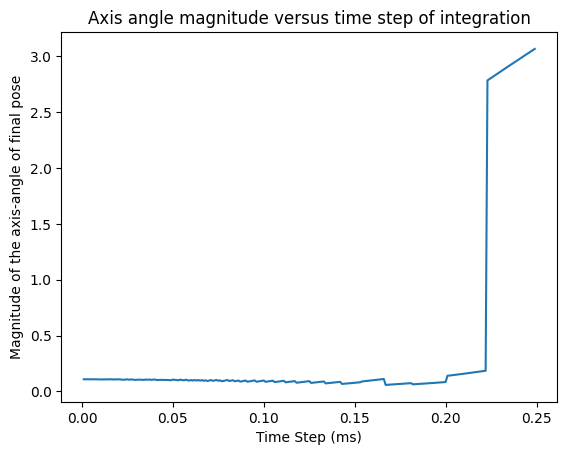

In [ ]:
plt.title('Axis angle magnitude versus time step of integration')
plt.xlabel('Time Step (ms)')
plt.ylabel('Magnitude of the axis-angle of final pose')
plt.plot(dtr,qmag)

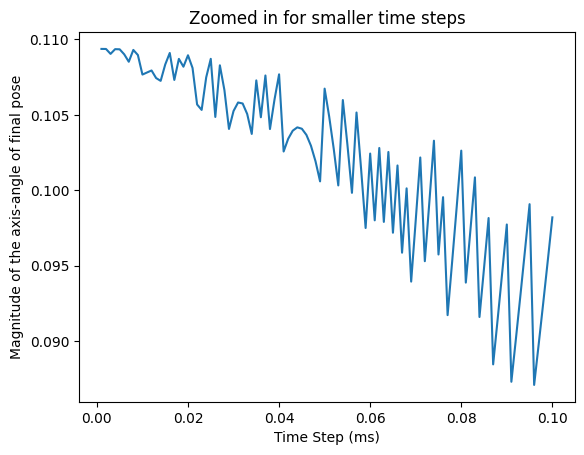

In [ ]:
plt.title('Zoomed in for smaller time steps')
plt.xlabel('Time Step (ms)')
plt.ylabel('Magnitude of the axis-angle of final pose')
plt.plot(dtr[0:100],qmag[0:100])

---
**Datasets**

https://github.com/dlaidig/broad has datasets of IMU measurements along with  ground truth. The ground truth is recorded using a optical motion tracking system.

Datasets under various conditions have been collected.

Read the associated paper for a more detailed description of the dataset.

In [ ]:
#down load one dataset from BROAD
!wget https://github.com/dlaidig/broad/raw/refs/heads/main/data_mat/01_undisturbed_slow_rotation_A.mat

--2025-01-14 15:22:52--  https://github.com/dlaidig/broad/raw/refs/heads/main/data_mat/01_undisturbed_slow_rotation_A.mat
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dlaidig/broad/refs/heads/main/data_mat/01_undisturbed_slow_rotation_A.mat [following]
--2025-01-14 15:22:52--  https://raw.githubusercontent.com/dlaidig/broad/refs/heads/main/data_mat/01_undisturbed_slow_rotation_A.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3865812 (3.7M) [application/octet-stream]
Saving to: ‘01_undisturbed_slow_rotation_A.mat’

01_undisturbed_slow 100%[===================>]   3.69M  --.-KB/s    in 0.0

In [ ]:
data = spio.loadmat("01_undisturbed_slow_rotation_A.mat")

In [ ]:
print(data.keys())
gyr = data['imu_gyr']
acc = data['imu_acc']
mag = data['imu_mag']
rot = QuatInverse(data['opt_quat']) #get the inverse ready to calculate error
dt = 1.0/data['sampling_rate'][0,0]
print(f"Sampling time step = {dt} s")


dict_keys(['__header__', '__version__', '__globals__', 'imu_gyr', 'imu_acc', 'imu_mag', 'opt_quat', 'opt_pos', 'sampling_rate', 'movement', 'info'])
Sampling time step = 0.0035 s


---
Lets look at a portion of the accelerometer and gyro waveforms

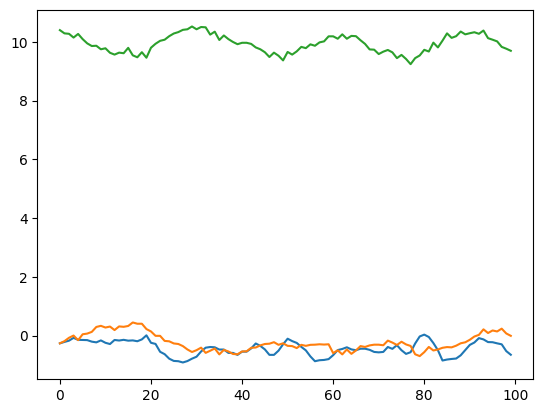

In [ ]:
tb = 10000
plt.plot(acc[tb:tb+100])

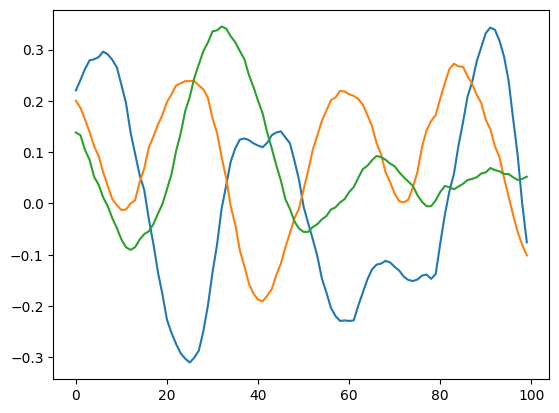

In [ ]:
plt.plot(gyr[tb:tb+100])

---
**Q3**
Integrate the angular changes into the quaternion and plot the error w..r.t ground truth (opt_quat).

In [ ]:
qerrMag=np.zeros(rot.shape[0])
q = np.zeros((rot.shape[0],4))
q[0] = QuatInverse(rot[0])
i=1
for w in gyr[:-2]:
  <your code>
  qerrMag[i] = <your code> #note this is the angle
  i=i+1

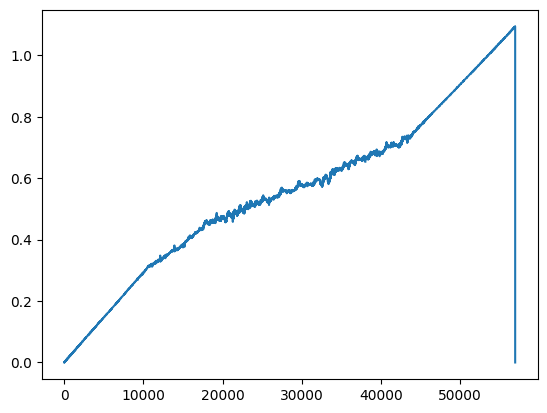

In [ ]:
plt.plot(qerrMag)

We observe that the angular pose drifts away.

---
**Q4**

Implement Laidig's algorithm 1 for 6DOF (only gyro and accel) and compare the error.

You may use scipy/s butterworth filter

In [ ]:
qerrMag=np.zeros(rot.shape[0])
q = np.zeros((rot.shape[0],4))
q[0] = QuatInverse(rot[0])
qi = np.zeros((rot.shape[0],4))
qi[0,0]= 1.
i=1
u = np.array([1.,0,0,0])
for w in gyr[:-2]:
  <your code>
  qerrMag[i] = <your code> #note this is the angle
  i=i+1

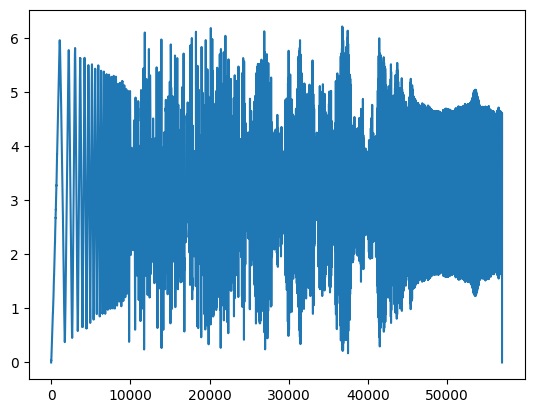

In [ ]:
plt.plot(qerrMag)

**Angular position - Integral of Angular Velocity**

For each of the three axis a measurement model for the angular velcoity is given as:

$\dot{\theta}^m(t)= \omega^m(t)=\omega(t)+n_{gr}(t)+b_{g}(t)$

Where:

$\omega(t)$ is the true angular velocity

$n_{gr}(t)$ is angular rate random noise modeled to have white spectral density

$b_{g}(t)$ is the randomness of the angular rate bias, due to slow drift of the bias and is modeled as a random walk of a white noise source:

$b_{g}(t) = \int_{-∞}^t n_{gb}(t) dt $

The anglular position is then obtained as:

$\theta(t) = \theta(t_0)+\int_{t_0}^{t} \omega(t)dt$

A sensor measures the signal at discrete time, with a sampling rate of $f_s$ Hz (or samples per second).

Usually, an anti-aliasing filter of bandwith $< \frac{f_s}{2}$ is used before the analog to digital converter in the electronics front end, to avoid aliasing (Nyquist theorem).

Thus for the $k^{th}$ time sample:

$\omega^m_k = \omega_k + n_{gr_k}+b_{g_k}$

$b_{g_k} = b_{g_{k-1}} + n_{gb_k}$

Here $n_{gr_k}$ and $n_{gb_k}$ are the sampled versions of the respective continous noise process.


The noise variances for the sampled case is obtained from the respective power spectral density of the continuous version as:

$\sigma_{gr}^s = \sigma_{gr}\sqrt{f_s}$

$\sigma_{gb}^s = \sigma_{gb}\sqrt{f_s}$

---
**Noise Spectral Density**

$n(t)$ is a random process (collection of random variables indexed by a continuous variable: t). Assume zero mean.

Auto-correlation: $R(t_1, t_1+\tau) = En(t_1)n(t_1+\tau)$

 $S_n(t_1, f) = FFT(R(t_1, t_1+\tau)) = \int e^{-i2\pi f\tau}R(t_1,t_1+\tau)d\tau$

is the power spectral density.

For a wide sense stationary process, $R(t_1, t_1+\tau) = R(\tau)$, i.e it is independant of $t_1$.

By Parseval's theoram

$\int |S(f)| df = R(0) = En^2(t)$ is the average power in the signal.

Hence $S(f)$ is the power spectral density - i.e. power per unit frequency.

For Random process where $n(t_1)$ and $n(t_2)$ are independent for all $t_1 \neq t_2$ then

$R(\tau) = \sigma^2 \delta(\tau)$ where $\sigma^2 = En^2(t)$ is the average power or variance and $\delta(\tau)$ is the Dirac delta function.


When such a noise is sampled in time with a sampling rate of $f_s$, usually we have a anti-aliasing filter (low pass filter_ of bandwidth $f_s/2$ before sampling - which restricts the total noise power after sampling to be

$\sigma^2 f_s$

Hence the $n(t)\ \ \ \tilde\ \ \ N(0,\sigma)$ after sampling at $f_s$ gives random variables $n_k\ \ \ \tilde\ \ \ N(0,\sigma\sqrt{f_s})$

---
**Specification of Angular Rate Random Noise**

Randomness due to white noise in rate measurement (when sampled at $f_s = \frac{1}{{\Delta}t}$:

$\theta_n(t_j-t_i) = \int_{t_i}^{t_j} n_{gr}(t) dt \approx \Sigma_{k=1}^N n_{gr_k} {\Delta}t$

is a random variable with zero mean and normal pdf with variance calculated as:

$\sigma_\theta(t)^2=Var(\theta_n(t)) \approx N {\Delta}t^2Var(n_{gr_k}) = t\sigma_{gr}^{2}$


Here $t_j-t_i = t = N\Delta t$


Thus noise (std. dev) grows as $\sqrt{t}$ and is called as a random walk.

This noise is specified either as a:

Angular Random Walk (ARW) as $\sigma_\theta(1)$: units of $(°/\sqrt{hr})$

or

Angular Rate Noise Density (ARND) $\sigma_{gr}$: units $°/hr/\sqrt{hz}$ or $°/s/\sqrt{hz}$

Note that you can convert between the two above as:

$ARW(°/\sqrt{hr})=\frac{1}{60}ARND(°/hr/\sqrt{hz})$

---
**Bias (in) Stability**

The bias slowly drifts over time. It is modeled as a random walk of a gaussian noise with spectral density $\sigma^2_{gb}$ specified in units of ($(\frac{°}{{s^{3/2}}{\sqrt{Hz}}}$) or as bias instability in units of $\frac{°}{hr}$ which represents a standard deviation of angle rate bias over a period of $\tau$ (this time depends on the device).

If $b_g(t_j)$ is the bias at time $t_j$ then

$b_g(t_i) = b_g(t_j) + \dot{\theta_{gb}}(t_i-t_j)$

where $\dot{\theta_{gb}}(t_i-t_j) \approx \Sigma_{k=1}^N n_{gb_k}{\Delta}t $

Hence $Var(\dot{\theta_{gb}}(t)) = \sigma_{\dot\theta_{gb}}(t)^2 \approx N {\Delta}t^2\sigma_{gb}^2f_s=\sigma_{gb}^2t$.

Manufacturers will usually spec  $\sigma_{\theta_{gb}}$ in $°/Hr$ - for a certain correlation time, $\tau$. Which means, the std. deviation for any other time, $t \gt \tau$, is: $\sigma_{\theta_{gb}}*\sqrt{t/\tau}$

For times $t \lt \tau$ we can model  the bias to be a constant.

---
**Pose State**

The pose  of the robot/camera/agent is the displacement position, angular position in some global coordinate frame.

The poses are elements of the Lie Group SE(3) and represented as a 4x4 matrix as:

$T_k = \begin{bmatrix} R_k & p_k \\ 0 & 1 \end{bmatrix}_{4\times4}$

Here $R_k$ is a $3\times3$ rotation matrix and $p_k$ is a $3\times 1$ column matrix for the displacement.

The rotation matrix is orthogonal, i.e.:
$R_kR_k^T=R_k^TR_k = I$

It has three degrees of freedom (through it has 9 entries). There are multiple ways of thiking about the rotation matrix:

- as a 3x3 matrix as above

- as 3x3 set of angular rotations $(\theta, \gamma, \phi)$ - also called Euler angles, about the three cartesian axes of the global reference frame

- as an axis angle representation in the form $\theta\bf{u}$ where $\bf{u}$ is a unit vector representing an axis about which an angle of $\theta$ rotation is made.

- Unit Quaternions - $q=\begin{bmatrix} cos(\theta) & \sin(\theta)\bf{u} \end{bmatrix}$ where  $\theta, \bf{u}$ is from above.

Of these, the matrix notation with axis-angle representation or the quarternions are the most convenient for calculations involving derivatives.

In this course we will use the matrix and axis-angle method.


---
**Transforms**

One will typically have multiple reference frames - the global or world frame, the body frame, camera frame etc.

Let the pose of the body in the global frame be $^GT$.

Then any vector in the body frame $^Bv$ gets transformed into global frame as:

$^Gv = ^GT\ ^Bv$

Thus $^Bv = ^GT^{-1}\ ^Gv = ^BT\ ^Gv$ with $^BT = ^GT^{-1}$

We will drop the superscriptsfor convenience - unless there is a need to make the context explicit.


Hence $^GT$ is not only the pose of the agent in the global frame - but also the transform which allows one to map a body vector to a global vector.

---
**IMU Equations**

*Measurements*

Angular velocity (measured in body frame):

$\omega^m_k = \omega_k + b_{g_k} +  n_{gr_k}$

Acceleration (measured in body frame):

$a^m_k = ^BR_k(a_k - \bf{g})$$\ + b_{a_k} + n_{ar_k}$

With $\bf{g}$ as the acceleration due to gravity.

$^BR_k=^GR_k^{-1}=^GR_k^T$

As discussed in the previous cells:

$n_{gr_k}\ \ \tilde \ \ \ N(0,\sigma_{gr}\sqrt{f_s}I_{3\times3})= N(0,\Sigma_{gr})$

$n_{ar_k}\ \ \tilde \ \ \ N(0,\sigma_{ar}\sqrt{f_s}I_{3\times3}) = N(0,\Sigma_{ar})$

and

$b_{g_{k+1}} = b_{g_k} + n_{gb_k}$

$b_{a_{k+1}} = b_{a_k} + n_{ab_k}$

With

$n_{gb_k}\ \ \tilde \ \ \ N(0,\sigma_{gb}\sqrt{f_s}I_{3\times3}) = N(0,\Sigma_{gb})$

$n_{ab_k}\ \ \tilde \ \ \ N(0,\sigma_{ab}\sqrt{f_s}I_{3\times3})= N(0,\Sigma_{ab})$


Using these measurements, we can track the pose state:

$T_k = \begin{bmatrix} R_k & p_k \\ 0 & 1 \end{bmatrix}$ (note that this is in Global frame - we have dropped superscript G)

as well as the two biases $b_{g_k}, b_{a_k}$ and the velocities $v_k$

*Prediction*

$R_{k+1} = R_k \oplus ((\omega^m_k - b_{g_k} - n_{gr_k}) \Delta t)$ (borrowing notation from Sola et. al., Micro-Lie Theory )

$v_{k+1} = v_k + R_k^T(a_k^m-b_{a_k} - n_{ar_k})\Delta t + \bf{g}$$\Delta t$

$p_{k+1} = p_k + v_k \Delta t + \frac{1}{2}\bf{g}$$\Delta t^2 + \frac{1}{2}a_k \Delta t^2 = p_k + v_k \Delta t + \frac{1}{2}\bf{g}$$\Delta t^2 + \frac{1}{2}R_k^T(a_k^m-b_{a_k} - n_{ar_k}) \Delta t^2$

With the biases $b_{g_{k+1}}$ and
$b_{a_{k+1}}$ evolving as given above.

---
**Summary of Key Results from Matrix Lie Theory**

Let $G$ be a set of matrices which under matrix multiplication forms a Lie Group (i.e. there is continuity).

$\forall X,Y \in G$ , then $XY \in G$

Example 1:

$SO(2) =\{ \begin{bmatrix}cos(\theta) & -sin(\theta) \\ sin(\theta) & cos(\theta) \end{bmatrix}|\theta \in ℝ \}$ is the set of 2x2 rotation matrices in 2D plane

$SE(2) : \{ \begin{bmatrix} cos(\theta) & -sin(\theta) & x \\ sin(\theta) & cos(\theta) & y \\ 0 & 0 & 1\end{bmatrix}|\theta,x,y \in ℝ \}$ is the set of matrices representing 2D rigid transform


 $\frak{g}$ is the corresponding Lie Algebra (also represented as Matrices).

Example 2:

$\frak{so(2)} = \{\begin{bmatrix} 0 & -\theta \\ \theta & 0 \end{bmatrix}|\theta \in ℝ\}$ is the Lie Algebra for $SO(2)$

$\frak{se(2)} = \{\begin{bmatrix} 0 & -\theta & \rho_x \\ \theta & 0 & \rho_y \\ 0 & 0 & 1\end{bmatrix}|\theta \in ℝ\}$ is the Lie Algebra for $SE(2)$

**Connection between $G$ and $\frak{g}$: The Exponential Map**

$\forall x^{\hat{}} \in \frak{g}:$ $ X=e^{x^{\hat{}}} \in G$

This can be realised via matrix exponentiation:

$X = I + x^{\hat{}} + \frac{x^{\hat{}2}}{2} + \frac{x^{\hat{}3}}{3} + ...$

*Example 1a:*

$e^{\begin{bmatrix} 0 & -\theta \\ \theta & 0 \end{bmatrix}} = \begin{bmatrix}cos(\theta) & -sin(\theta) \\ sin(\theta) & cos(\theta) \end{bmatrix}$


---
In the above equations, $R_k, p_k, v_k$ and the biases are random variables.

Hence at a minimum we would like to know their means and variances.

A full distribution will allow calculation of other statistics (median, percentiles etc).

The phyiscal noise variables are assumed  be Gaussian (which is physically justifiable in many cases).

If all equations are linear in the random variables, then gaussian-ness is preserved.

However a gaussian variable passing through a non-linear funciton loses its Gaussianness.

But - in order to keep the computations tractable, we still model the output variables (of the non-linear) function as Gaussians.

This technique is used to extend kalman filters to cases where the system and observation equations are non-linear (giving EKF)

Let $y = f(x)$ and $x\ \tilde \ \ N(\mu_x, \Sigma_x)$

Then for small perturbations $n$, in  $x$,

$y \approx f(x) + J n$

Here $J$ is the Jacobian.

Let $y=(y_1,y_2,...,y_n)$ and $x=(x_1, x_2, ...., x_m)$ then

$J = \begin{bmatrix} \frac{\delta y_1}{\delta x_1} & \frac{\delta y_1}{\delta x_2} & ... & \frac{\delta y_1}{\delta x_m}\\ \frac{\delta y_2}{\delta x_1} & \frac{\delta y_2}{\delta x_2} & ... & \frac{\delta y_2}{\delta x_m}\\ ...\\\frac{\delta y_n}{\delta x_1} & \frac{\delta y_n}{\delta x_2} & ... & \frac{\delta y_n}{\delta x_m}\\ \end{bmatrix}_{n\times m}$

Modeling $x = \mu_x + n$, with $n$ as 0 mean random vector with covariance $\Sigma_x$, we can get covariance of $y$ as

$\Sigma_y = J\Sigma_xJ^T$

---
**Calculating Jacobians for Lie Group Operations**

*Differentiation in Lie Groups*

Let $f : G → H$ be a function between two Lie Groups.

Then the right derivative along a tangent vector $v$ is:

$\frac{Df}{DX} = lt_{h→0} \frac{f(X\oplus hv) \ominus f(X) }{h}$

with $X \in G$ and $\oplus$ is for $G$ and $\ominus$ for H

So the Jacobian of $f$ is the matrix $J$ where the $i^{th}$ column is the directional derivative along the $i^{th}$ basis vector $e_i$.

$J = \begin{bmatrix} J_1 & J_2 & ... J_n\end{bmatrix}$ with $J_i = lt_{h→0} \frac{f(X\oplus he_i) \ominus f(X) }{h}$

*Example 1:*

Consider a function $f:SO(3) → ℝ^3$ which maps some vector $p$ to $Rp$ where $R \in SO(3)$

Then $J_i = \frac{Df}{DR} = lt_{h→0} \frac{f(R\oplus e_i)\ominus f(R)}{h} = lt_{h→0}\frac{RExp(he_i)p-Rp}{h}=lt_{h\rightarrow 0} \frac{R(I+h[e_i]_\times+h^2...)p-Rp}{h} = R[e_i]_\times p = -R[p]_\times e_i$

Therefore $J=-R[p]_\times$

*Example 2*

Let $f: G \times  G → G$  such that $(X,Y) → X\cdot Y = XY$ (group operation)

Then $J_X e_i = \frac{D{XY}}{dX} = lt_{h→0}\frac{(X\oplus e_i)Y \ominus XY}{h} = \frac{Log((XY)^{-1}XExp(he_i)Y)}{h}=\frac{Log(Exp(hY^{-1}e_i{Y})}{h}=Ad_{Y^-1}e_i$

($e_i$ is the unit vector along the $i^{th}$ axis)

Hence $J=Ad_{Y^{-1}}$

*Note*

If $R$ is a rotation matrix, then $Ad_R = R$ as
$[Ad_R(v)]_\times = R [v]_\times R = [Rv]_\times$


*Jacobians for IMU equations*

The main challenge of obtaining Jacobian for IMU equations is for the one involving rotation.

Suppose $R_{k+1} = R_k \oplus v$ where $v \in ℝ^3$ and let $v = \theta u $ with $\theta=||v||$ angle of rotation about unit normal $u = \frac{v}{||v||}$


Let $R_k = e^{[r_k]_\times}=Exp(r_k)$ where $r_k \in ℝ^3$ .

The covariance of $R_k$ is represented in terms of the Covariance of $r_k$ as $\Sigma_{R_k}$

Let covariance of $v$ be $\Sigma_v$.

Then covariance of $R_{k+1}$ is:

$\Sigma_{R_{k+1}} = J_{R_k}\Sigma_{R_k}J_{R_k}^T + J_r (v) \Sigma_v J_r(v)^T$

$J_{R_k} = Ad_{Exp(-v)} = Exp(-v)$ (see example 2 above)

And

$J_r(v) = I - \frac{1-cos(\theta)}{\theta^2}[u]_\times + \frac{\theta-sin(\theta)}{\theta^3}[u]_\times^2$ (Eq 143,  Sola)

Hence,

$\Sigma_{R_{k+1}} = Exp(-v)\Sigma_{R_k}Exp(v) + J_r(v)\Sigma_v J_r(v)^T$


---
**2D Robot**


Consider a robot in a 2D plane. Its pose at time $k$ is given by the  3x1 vector: $L_k = \begin{bmatrix} \theta_k \\ x_k \\ v_k \end{bmatrix}$ where $\theta_k$ is the yaw angle (counter clockwise rotation about the vertical - Z axis), $(x_k,y_k)$ is the location in the 2D cartesian plane.


Assume that the robot has an IMU, which measures the angular velocity and acceleration.

---
**Q5**

Let the measurements on angular (rad/s) and linear velocities (m/s) (in the robot's body frame) at time indexes  $k$ be
$ \begin{bmatrix} \omega_k \\ v_{x_k} \\ v_{y_k} \end{bmatrix}$ and sampling time $dt$

Let the pose of the robot at time k be $T_k = \begin{bmatrix} R_k & d_k \\ 0 & 1\end{bmatrix} \in SE(2)$

Write the equations for the $SE(2)$ pose at time index $k+1$ given the above measurements

Ans:

$T_{k+1} = $

---
**Q6**

Find the Jacobian of the pose $T_{k+1}$ with respect to


a) angular position \\
b) displacement \\
c) angular rate \\
d) velocity \\
at time $k$

(Hint: Refer to the paper by Sola et. al., Micro-Lie Theory)

Ans:




---
**Q7**

If the covariance in angular velocity and linear velocity measurements are $\sigma_\omega^2$ and $\Sigma_v$, and the covariance in the pose is $\Sigma_k$, find the covariance in the pose at time $k+1$

Ans:



---
**Q8**

Lets use the IMU measurement model from above for Yaw (rotation about the z-axis)  and  acceleration in 2D plane measurements.

Write the state equations for the system (include the bias instability of the gyro and accelerometer as part of the state)


Ans:





---
**Q9**

Find the mean and covariance of $T_{k+1}$ given the covariances of all random vectors.

Ans:


